In [1]:
from skimage import filters, io, draw, transform, measure, segmentation, color, morphology
from skimage.future import graph
import numpy as np
from sklearn import preprocessing, cluster
import matplotlib.pyplot as pl
import math
import pandas as pd
import matplotlib.patches as mpatches
from scipy import ndimage, spatial

from slice_tools import *
from data_tools import *
from processing_tools import *

In [2]:
filePath = '/Users/s1101153/Desktop/TIFs/'
infoFile = '/Users/s1101153/Dropbox/Emily/z-stack_info.csv'

In [3]:
if input('Re-calculate image slices? y/n: ') == 'y':
    rad=80
    print('Re-calculating slices...')
    f = open(infoFile, 'r')
    first_time=True
    for line in f.readlines():
        if line.startswith('SUM'):
            vals=line.split(',')
            fileName = filePath+vals[0]
            umSize=float(vals[1])
            L=int(vals[2])
            Cx=float(vals[4])
            Cy=float(vals[3])
            g_index=int(vals[5]) #call the fuller channel the green one
            r_index=int(vals[6]) #call the sparser channel the red one
            n_slice = 12
            if(first_time):
                slices = read_slice(fileName, L, umSize, Cx, Cy, g_index, r_index)
                first_time=False
            else:
                newslice = read_slice(fileName, L, umSize, Cx, Cy, g_index, r_index)
                slices = pd.concat([slices, newslice], axis=0)
    f.close() 
    slices
    slices.to_pickle('/Users/s1101153/Dropbox/Emily/nice_slices.pkl')
    print('New slices saved')
else:
    print('Reading saved slices')
    slices=pd.read_pickle('/Users/s1101153/Dropbox/Emily/nice_slices.pkl')

Re-calculate image slices? y/n: n
Reading saved slices


In [4]:
# i=0
av_connected_area = list()
av_separation = list()
area_sum = list()
av_circularity = list()
for s in slices['imArray']:
    lab_im = threshold_and_label(s, highpass = False)
    areas=list()
    centres=list()
    circs=list()
    for region in measure.regionprops(lab_im):
        areas.append(region.area)
        centres.append(region.centroid)
        if region.perimeter ==0:
            circ = 0
        else:
            circ = 4*math.pi*region.area/region.perimeter**2
        circs.append(circ)
        
    av_connected_area.append(np.mean(areas))
    
    distances = spatial.distance.pdist(centres)
    av_separation.append(np.mean(distances))
    
    area_sum.append(np.sum(areas))

    av_circularity.append(np.mean(circs))
    
    
#     if len(areas)>0:
#         print(str(i) + ': ' + str(np.mean(areas)))
#     else:
#         print(str(i) + ': 0')
#         print(str(i) + ': ' + str(np.mean(areas)))
#     i=i+1

slices['av_connected_area'] = av_connected_area
slices['av_separation'] = av_separation
slices['area_sum'] = area_sum
slices['av_circularity'] = av_circularity

/Users/s1101153/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/s1101153/.local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


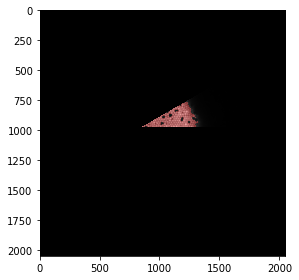

In [5]:
s=slices['imArray'][10]
lab_im = threshold_and_label(s, highpass = False)
areas=list()
for region in measure.regionprops(lab_im):
    areas.append(region.area)
measure.regionprops(lab_im)
image_label_overlay = color.label2rgb(lab_im, image=s, bg_label=0)
io.imshow(image_label_overlay)


In [6]:
slices

imArray  \
sample   colour slice                                                      
T3M_7_1  green  0      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                1      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                2      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                3      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                4      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                                  ...   
T6M_30_2 red    7      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                8      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                9      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                10     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                11     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                       av_connected_area  av_separation  area_sum  \
sample   colour slice                                               
T3M_7_1  green  0            7646.166667     181.307559     45877   
                1           11835.000000     134.808705     35505   
                2           10570.666667     104.334078     31712   
                3           17996.000000     143.463545     35992   
                4            7732.600000     116.544606     38663   
...                                  ...            ...       ...   
T6M_30_2 red    7             786.583333     132.544138      9439   
                8             899.153846     120.417928     11689   
                9             554.500000     122.051338      9981   
                10            934.153846     120.221277     12144   
                11           1481.375000     143.741874     11851   

                       av_circularity  
sample   colour slice                  
T3M_7_1  green  0            6.931346  
                1            1.659061  
                2            1.192981  
                3            0.607282  
                4            1.020858  
...                               ...  
T6M_30_2 red    7            0.653135  
                8            0.811338  
                9            0.728727  
                10           0.686489  
                11           0.642890  

[192 rows x 5 columns]

In [8]:
np.random.seed(1234)
dat_all = slices.drop(['imArray'],axis=1).dropna()
kmeans=cluster.KMeans(n_clusters=8).fit(dat_all)
labs=kmeans.labels_

k_clusters = pd.DataFrame(labs, index=dat_all.index, columns=['cluster_all'])

k_clusters.describe()

,cluster_all
count,187.000000
mean,2.358289
std,1.650993
min,0.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,7.000000


In [9]:
np.random.seed(1234)
dat_area_sep=dat_all.drop(['area_sum','av_circularity'], axis=1)
print(dat_area_sep)
kmeans_area_sep=cluster.KMeans(n_clusters=8).fit(dat_area_sep)
labs_area_sep=kmeans_area_sep.labels_

k_clusters['cluster_area_sep'] = labs_area_sep

                       av_connected_area  av_separation
sample   colour slice                                  
T3M_7_1  green  0            7646.166667     181.307559
                1           11835.000000     134.808705
                2           10570.666667     104.334078
                3           17996.000000     143.463545
                4            7732.600000     116.544606
...                                  ...            ...
T6M_30_2 red    7             786.583333     132.544138
                8             899.153846     120.417928
                9             554.500000     122.051338
                10            934.153846     120.221277
                11           1481.375000     143.741874

[187 rows x 2 columns]


In [10]:
np.random.seed(1234)
dat_sum_circ=dat_all.drop(['av_connected_area','av_separation'], axis=1)
print(dat_sum_circ)
kmeans_sum_circ=cluster.KMeans(n_clusters=8).fit(dat_sum_circ)
labs_sum_circ=kmeans_sum_circ.labels_

k_clusters['cluster_sum_circ'] = labs_sum_circ

                       area_sum  av_circularity
sample   colour slice                          
T3M_7_1  green  0         45877        6.931346
                1         35505        1.659061
                2         31712        1.192981
                3         35992        0.607282
                4         38663        1.020858
...                         ...             ...
T6M_30_2 red    7          9439        0.653135
                8         11689        0.811338
                9          9981        0.728727
                10        12144        0.686489
                11        11851        0.642890

[187 rows x 2 columns]


In [11]:
np.random.seed(1234)
dat_area_sum=dat_all.drop(['av_separation','av_circularity'], axis=1)
print(dat_area_sum)
kmeans_area_sum=cluster.KMeans(n_clusters=8).fit(dat_area_sum)
labs_area_sum=kmeans_area_sum.labels_

k_clusters['cluster_area_sum'] = labs_area_sum

                       av_connected_area  area_sum
sample   colour slice                             
T3M_7_1  green  0            7646.166667     45877
                1           11835.000000     35505
                2           10570.666667     31712
                3           17996.000000     35992
                4            7732.600000     38663
...                                  ...       ...
T6M_30_2 red    7             786.583333      9439
                8             899.153846     11689
                9             554.500000      9981
                10            934.153846     12144
                11           1481.375000     11851

[187 rows x 2 columns]


In [12]:
np.random.seed(1234)
dat_area_circ=dat_all.drop(['av_separation','area_sum'], axis=1)
print(dat_area_circ)
kmeans_area_circ=cluster.KMeans(n_clusters=8).fit(dat_area_circ)
labs_area_circ=kmeans_area_circ.labels_

k_clusters['cluster_area_circ'] = labs_area_circ

                       av_connected_area  av_circularity
sample   colour slice                                   
T3M_7_1  green  0            7646.166667        6.931346
                1           11835.000000        1.659061
                2           10570.666667        1.192981
                3           17996.000000        0.607282
                4            7732.600000        1.020858
...                                  ...             ...
T6M_30_2 red    7             786.583333        0.653135
                8             899.153846        0.811338
                9             554.500000        0.728727
                10            934.153846        0.686489
                11           1481.375000        0.642890

[187 rows x 2 columns]


In [13]:
np.random.seed(1234)
dat_sep_circ=dat_all.drop(['area_sum','av_connected_area'], axis=1)
print(dat_sep_circ)
kmeans_sep_circ=cluster.KMeans(n_clusters=8).fit(dat_sep_circ)
labs_sep_circ=kmeans_sum_circ.labels_

k_clusters['cluster_sep_circ'] = labs_sep_circ

                       av_separation  av_circularity
sample   colour slice                               
T3M_7_1  green  0         181.307559        6.931346
                1         134.808705        1.659061
                2         104.334078        1.192981
                3         143.463545        0.607282
                4         116.544606        1.020858
...                              ...             ...
T6M_30_2 red    7         132.544138        0.653135
                8         120.417928        0.811338
                9         122.051338        0.728727
                10        120.221277        0.686489
                11        143.741874        0.642890

[187 rows x 2 columns]


In [14]:
np.random.seed(1234)
dat_sum_sep=dat_all.drop(['av_connected_area','av_circularity'], axis=1)
print(dat_sum_sep)
kmeans_sum_sep=cluster.KMeans(n_clusters=8).fit(dat_sum_sep)
labs_sum_sep=kmeans_sum_sep.labels_

k_clusters['cluster_sum_sep'] = labs_sum_sep

                       av_separation  area_sum
sample   colour slice                         
T3M_7_1  green  0         181.307559     45877
                1         134.808705     35505
                2         104.334078     31712
                3         143.463545     35992
                4         116.544606     38663
...                              ...       ...
T6M_30_2 red    7         132.544138      9439
                8         120.417928     11689
                9         122.051338      9981
                10        120.221277     12144
                11        143.741874     11851

[187 rows x 2 columns]


In [15]:
dat_toPlot = k_clusters.reset_index()
dat_toPlot
cluster_count = count_clusters(dat_toPlot, counter='cluster_all', grouper1='sample', grouper2='colour')
cluster_count_area_sep=count_clusters(dat_toPlot, counter='cluster_area_sep', grouper1='sample', grouper2='colour')
cluster_count_sum_circ=count_clusters(dat_toPlot, counter='cluster_sum_circ', grouper1='sample', grouper2='colour')
cluster_count_area_sum=count_clusters(dat_toPlot, counter='cluster_area_sum', grouper1='sample', grouper2='colour')
cluster_count_area_circ=count_clusters(dat_toPlot, counter='cluster_area_circ', grouper1='sample', grouper2='colour')
cluster_count_sep_circ=count_clusters(dat_toPlot, counter='cluster_sep_circ', grouper1='sample', grouper2='colour')
cluster_count_sum_sep=count_clusters(dat_toPlot, counter='cluster_sum_sep', grouper1='sample', grouper2='colour')


/Users/s1101153/Git/droplets/data_tools.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_small['MergedID'] = dat_small[counter].apply(str)+dat_small['Entry']


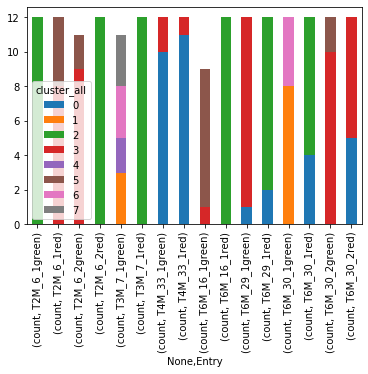

In [16]:
cluster_count.transpose().plot(kind='bar', stacked = True)


In [17]:
gini_scores = pd.DataFrame(index=dat_all.index.droplevel(2).drop_duplicates())
gini_scores['all'] = gini_score(cluster_count)
gini_scores['area_sep'] = gini_score(cluster_count_area_sep)
gini_scores['sum_circ'] = gini_score(cluster_count_sum_circ)
gini_scores['area_sum'] = gini_score(cluster_count_area_sum)
gini_scores['area_circ'] = gini_score(cluster_count_area_circ)
gini_scores['sep_circ'] = gini_score(cluster_count_sep_circ)
gini_scores['sum_sep'] = gini_score(cluster_count_sum_sep)

gini_scores

all  area_sep  sum_circ  area_sum  area_circ  sep_circ  \
sample   colour                                                                
T3M_7_1  green   0.000000  0.000000  0.375000  0.000000   0.000000  0.375000   
         red     0.444444  0.680556  0.277778  0.444444   0.680556  0.277778   
T2M_6_1  green   0.297521  0.595041  0.462810  0.297521   0.595041  0.462810   
         red     0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   
T2M_6_2  green   0.743802  0.760331  0.661157  0.743802   0.760331  0.661157   
         red     0.000000  0.000000  0.500000  0.000000   0.000000  0.500000   
T4M_33_1 green   0.277778  0.444444  0.152778  0.277778   0.444444  0.152778   
         red     0.152778  0.375000  0.277778  0.152778   0.375000  0.277778   
T6M_30_1 green   0.197531  0.641975  0.493827  0.197531   0.641975  0.493827   
         red     0.000000  0.000000  0.444444  0.000000   0.000000  0.444444   
T6M_16_1 green   0.152778  0.486111  0.152778  0.152778   0.486111  0.152778   
         red     0.277778  0.000000  0.000000  0.277778   0.000000  0.000000   
T6M_29_1 green   0.444444  0.819444  0.375000  0.444444   0.819444  0.375000   
         red     0.444444  0.000000  0.402778  0.444444   0.000000  0.402778   
T6M_30_2 green   0.277778  0.583333  0.375000  0.277778   0.583333  0.375000   
         red     0.486111  0.444444  0.569444  0.486111   0.444444  0.569444   

                  sum_sep  
sample   colour            
T3M_7_1  green   0.375000  
         red     0.277778  
T2M_6_1  green   0.462810  
         red     0.000000  
T2M_6_2  green   0.661157  
         red     0.500000  
T4M_33_1 green   0.152778  
         red     0.277778  
T6M_30_1 green   0.493827  
         red     0.444444  
T6M_16_1 green   0.152778  
         red     0.000000  
T6M_29_1 green   0.375000  
         red     0.402778  
T6M_30_2 green   0.375000  
         red     0.569444

In [18]:
gini_scores.mean(axis=0)

all          0.262324
area_sep     0.364418
sum_circ     0.345036
area_sum     0.262324
area_circ    0.364418
sep_circ     0.345036
sum_sep      0.345036
dtype: float64

In [19]:
dat_ACF = pd.read_csv('/Users/s1101153/Dropbox/Emily/Results/2020-05-26_ACF_clusters_3pt-av_small.csv', index_col=0)
cluster_count_ACF=count_clusters(dat_ACF, counter='Cluster', grouper1='Sample', grouper2='Colour')
gini_ACF = np.mean(gini_score(cluster_count_ACF))
print('ACF: '+str(gini_ACF))

ACF: 0.4104938271604938


In [20]:
dat_raw = pd.read_csv('/Users/s1101153/Dropbox/Emily/Results/2020-04-30_k_h_av20r_9h-clusters.csv', index_col=0)
cluster_count_raw = count_clusters(dat_raw, counter='Cluster_kmeans', grouper1='Sample', grouper2='Colour')
cluster_count_hier = count_clusters(dat_raw, counter='Cluster_hier', grouper1='Sample', grouper2='Colour')

gini_raw = np.mean(gini_score(cluster_count_raw))
gini_hier = np.mean(gini_score(cluster_count_hier))
print('Raw (kmeans): '+str(gini_raw) + '\nHierarchical: '+ str(gini_hier))

Raw (kmeans): 0.31635802469135804
Hierarchical: 0.7407407407407408


A lower score is better, so (not accounting for combinations across the 3 approaches) it seems that the variables derived from labelling the image give the best score, followed closely by the raw rectangular data. In particular the combination of average connected area and sum of areas (proxy for area fraction of particles) performs as well as the combination of all 4 labelling variables, showing that the average separation of connected areas and the circularity of connected areas do not add any useful information.